In [1]:
import warnings; warnings.filterwarnings("ignore", message="Initializing zero-element tensors is a no-op")
import pandas as pd
import torch
import os 
from eval_utils import get_pairs, eval_epochs, MNISTSingleDataset

import sys
sys.path.insert(0, '../')

from utils import aug_transform, simple_transform
from models.mini_inception_resnet_v1 import MiniInceptionResNetV1
from models.omoindrot import Omoindrot

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

IMAGES_PATH = '../data/'
EPOCHS_PATH = '../checkpoints/'

In [2]:
test_df = pd.read_csv('../data/mnist_test.csv')
print(f'Test data shape: {test_df.shape}')

pairs = get_pairs(test_df, 1000)
print(f'Pairs shape: {pairs.shape}')

Test data shape: (10000, 785)
Pairs shape: (1000, 3)


In [3]:
pairs.head(1)

,img1,img2,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1


Calculating distances: 100%|██████████| 32/32 [00:02<00:00, 11.15it/s]


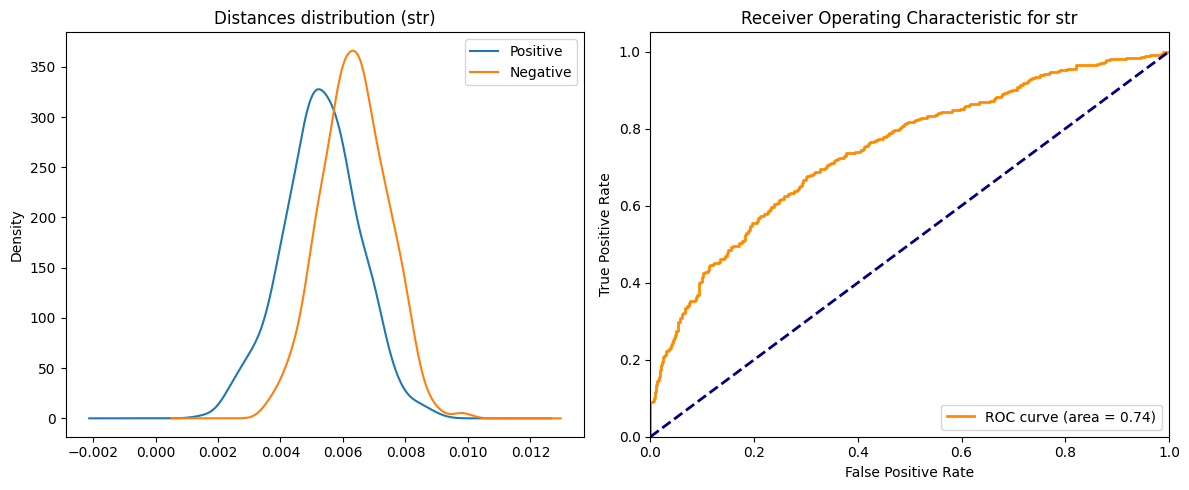

Target FAR: 1e-03 | Threshold: 0.0036
[epoch_1.pt] Accuracy: 0.5440
[epoch_1.pt] VAL: 0.0880 | FAR: 0.0000

[epoch_1.pt] Positive mean: 0.0053 ± 0.0012
[epoch_1.pt] Negative mean: 0.0064 ± 0.0011


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 77.21it/s]


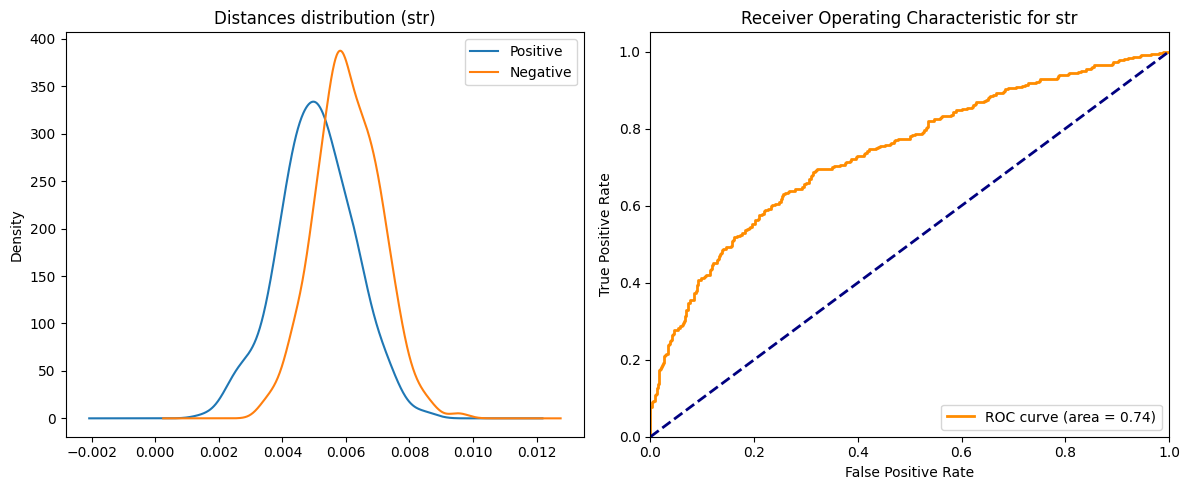

Target FAR: 1e-03 | Threshold: 0.0034
[epoch_2.pt] Accuracy: 0.5370
[epoch_2.pt] VAL: 0.0740 | FAR: 0.0000

[epoch_2.pt] Positive mean: 0.0051 ± 0.0012
[epoch_2.pt] Negative mean: 0.0061 ± 0.0010


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 103.95it/s]


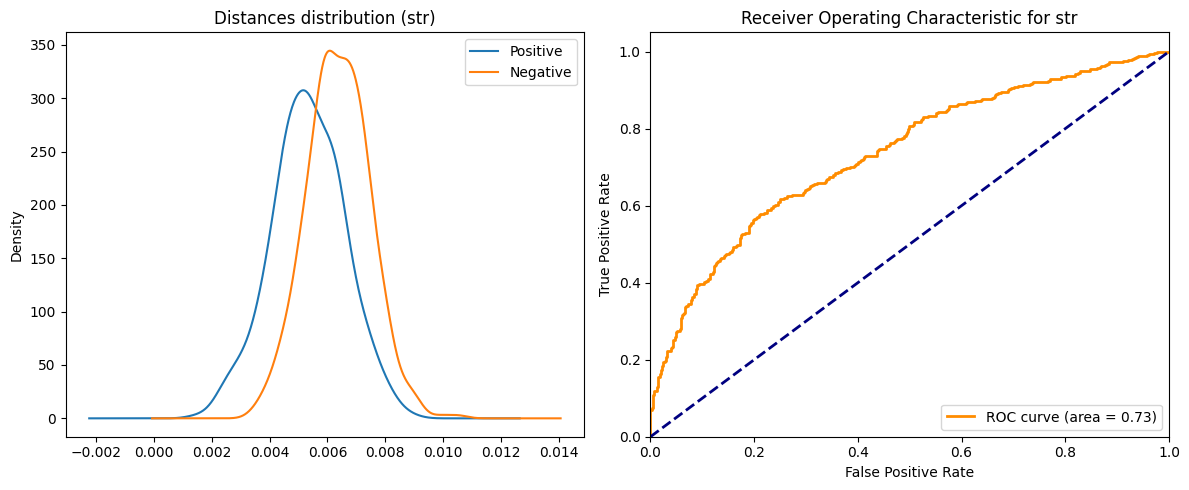

Target FAR: 1e-03 | Threshold: 0.0035
[epoch_3.pt] Accuracy: 0.5340
[epoch_3.pt] VAL: 0.0680 | FAR: 0.0000

[epoch_3.pt] Positive mean: 0.0053 ± 0.0013
[epoch_3.pt] Negative mean: 0.0064 ± 0.0011


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 100.72it/s]


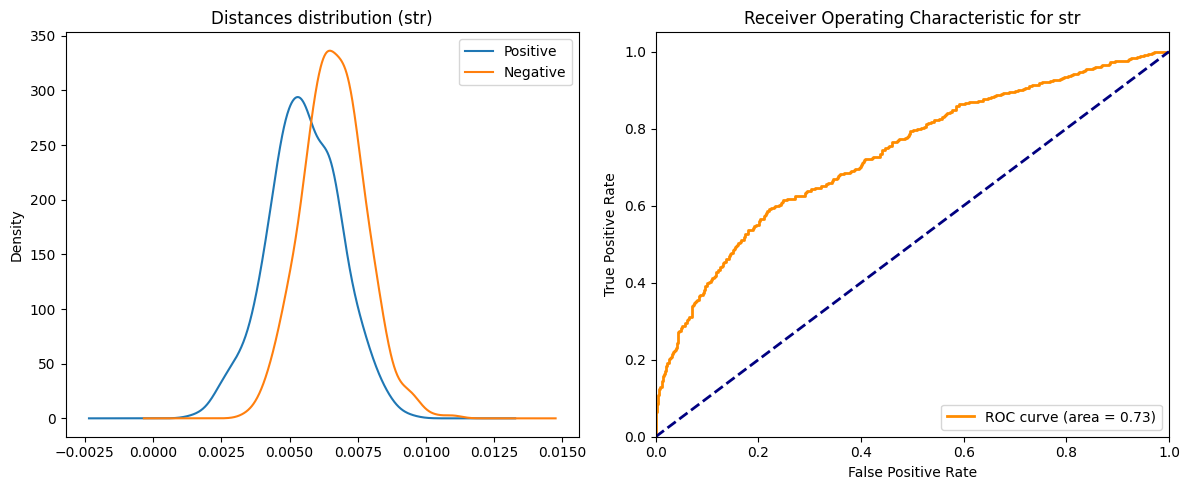

Target FAR: 1e-03 | Threshold: 0.0034
[epoch_4.pt] Accuracy: 0.5310
[epoch_4.pt] VAL: 0.0620 | FAR: 0.0000

[epoch_4.pt] Positive mean: 0.0055 ± 0.0013
[epoch_4.pt] Negative mean: 0.0066 ± 0.0011


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 115.51it/s]


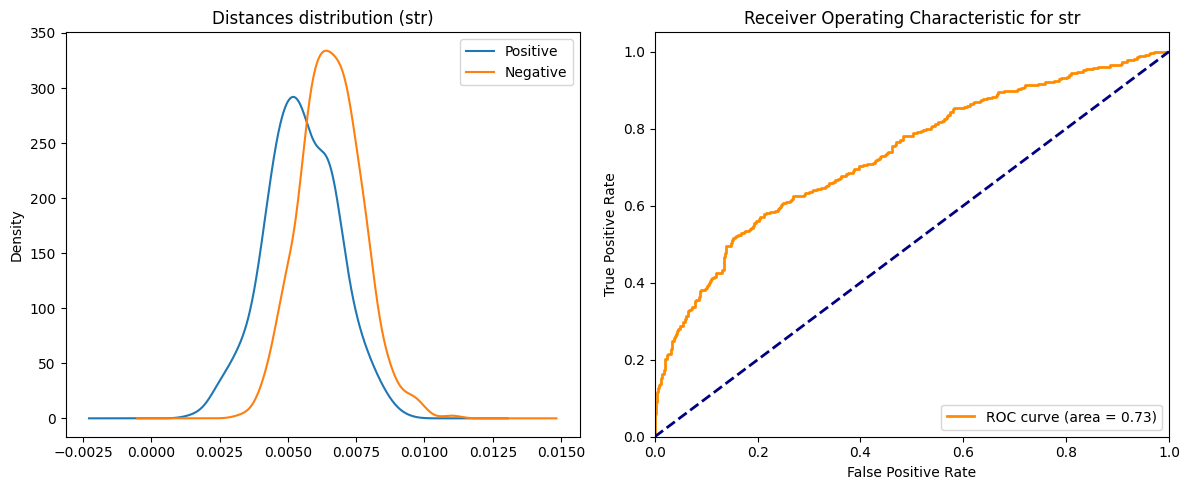

Target FAR: 1e-03 | Threshold: 0.0033
[epoch_5.pt] Accuracy: 0.5290
[epoch_5.pt] VAL: 0.0580 | FAR: 0.0000

[epoch_5.pt] Positive mean: 0.0055 ± 0.0013
[epoch_5.pt] Negative mean: 0.0066 ± 0.0011


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 101.07it/s]


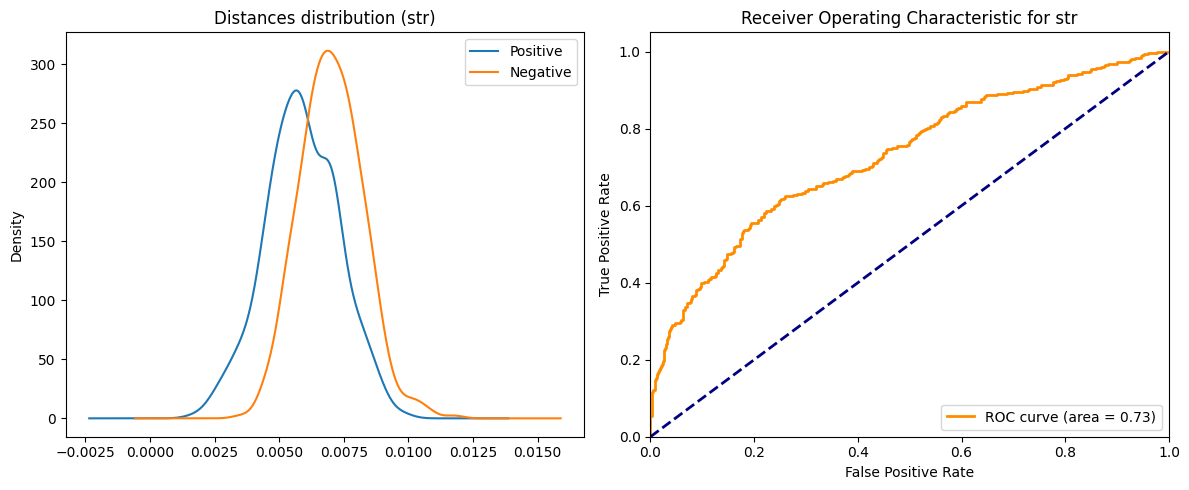

Target FAR: 1e-03 | Threshold: 0.0035
[epoch_6.pt] Accuracy: 0.5260
[epoch_6.pt] VAL: 0.0520 | FAR: 0.0000

[epoch_6.pt] Positive mean: 0.0059 ± 0.0014
[epoch_6.pt] Negative mean: 0.0070 ± 0.0012


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 105.00it/s]


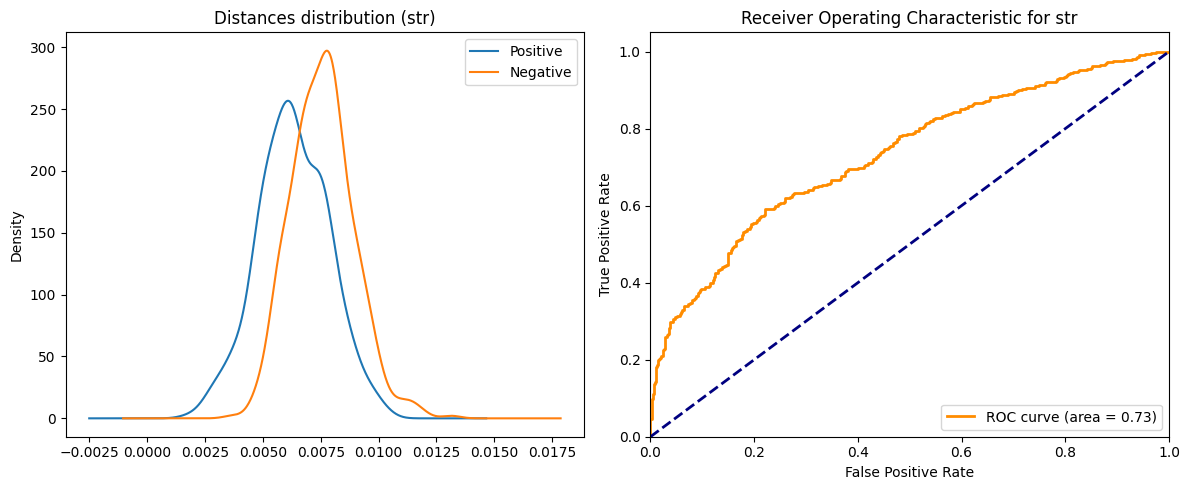

Target FAR: 1e-03 | Threshold: 0.0037
[epoch_7.pt] Accuracy: 0.5220
[epoch_7.pt] VAL: 0.0440 | FAR: 0.0000

[epoch_7.pt] Positive mean: 0.0063 ± 0.0015
[epoch_7.pt] Negative mean: 0.0076 ± 0.0013


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 115.44it/s]


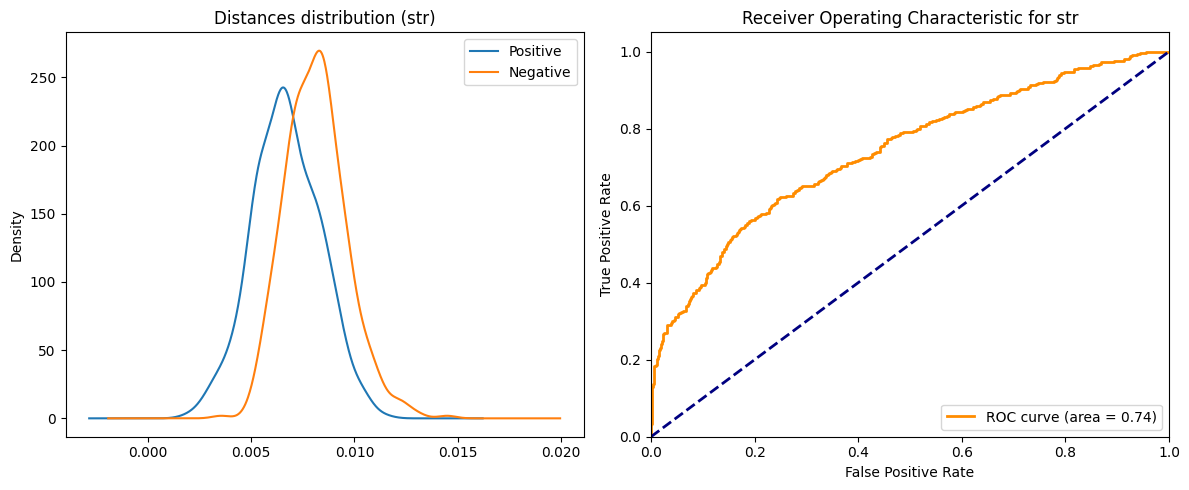

Target FAR: 1e-03 | Threshold: 0.0035
[epoch_8.pt] Accuracy: 0.5150
[epoch_8.pt] VAL: 0.0300 | FAR: 0.0000

[epoch_8.pt] Positive mean: 0.0067 ± 0.0016
[epoch_8.pt] Negative mean: 0.0081 ± 0.0015


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 113.57it/s]


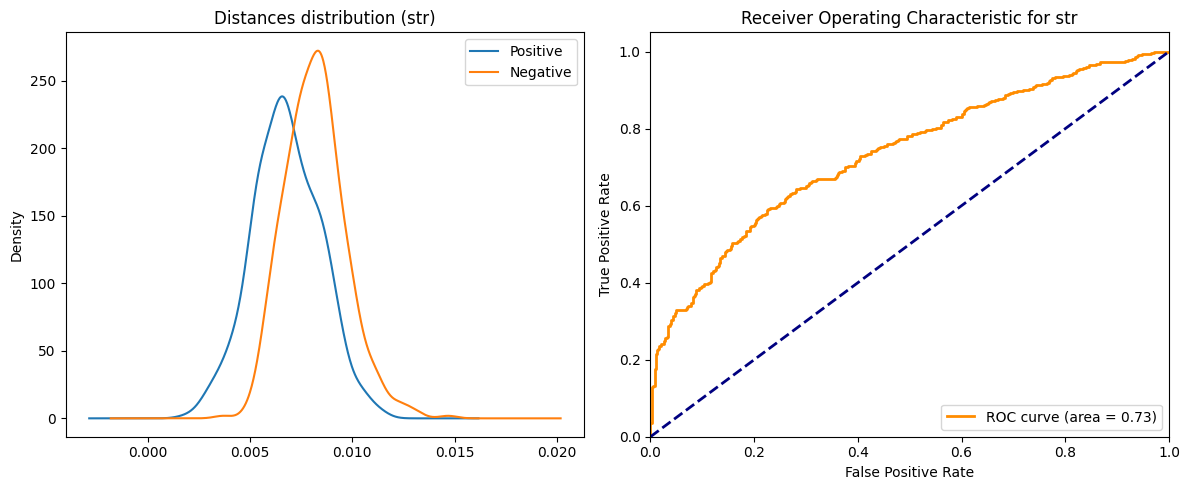

Target FAR: 1e-03 | Threshold: 0.0037
[epoch_9.pt] Accuracy: 0.5170
[epoch_9.pt] VAL: 0.0340 | FAR: 0.0000

[epoch_9.pt] Positive mean: 0.0068 ± 0.0017
[epoch_9.pt] Negative mean: 0.0082 ± 0.0015


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 46.37it/s]


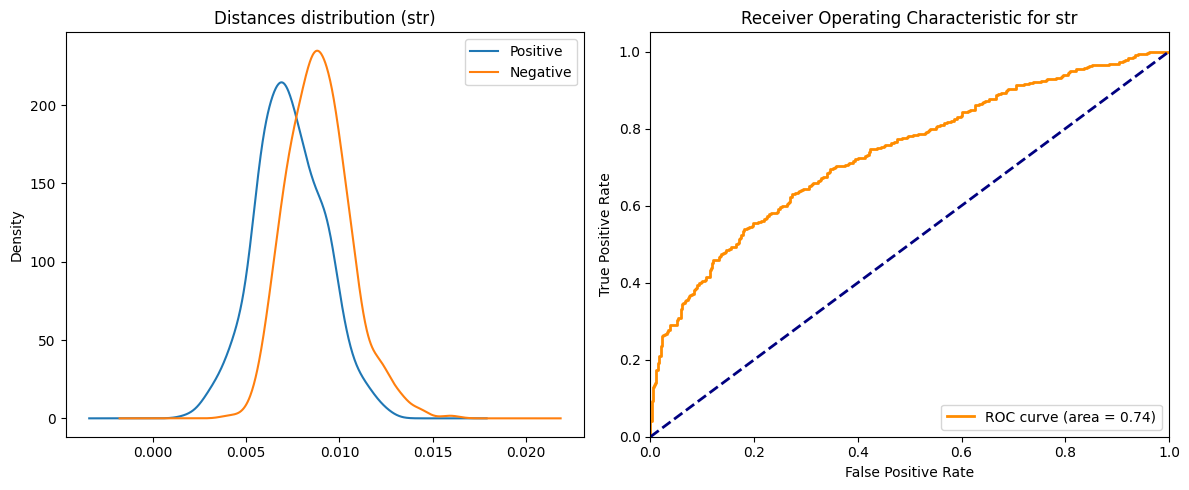

Target FAR: 1e-03 | Threshold: 0.0041
[epoch_10.pt] Accuracy: 0.5200
[epoch_10.pt] VAL: 0.0400 | FAR: 0.0000

[epoch_10.pt] Positive mean: 0.0073 ± 0.0018
[epoch_10.pt] Negative mean: 0.0089 ± 0.0017


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 87.09it/s]


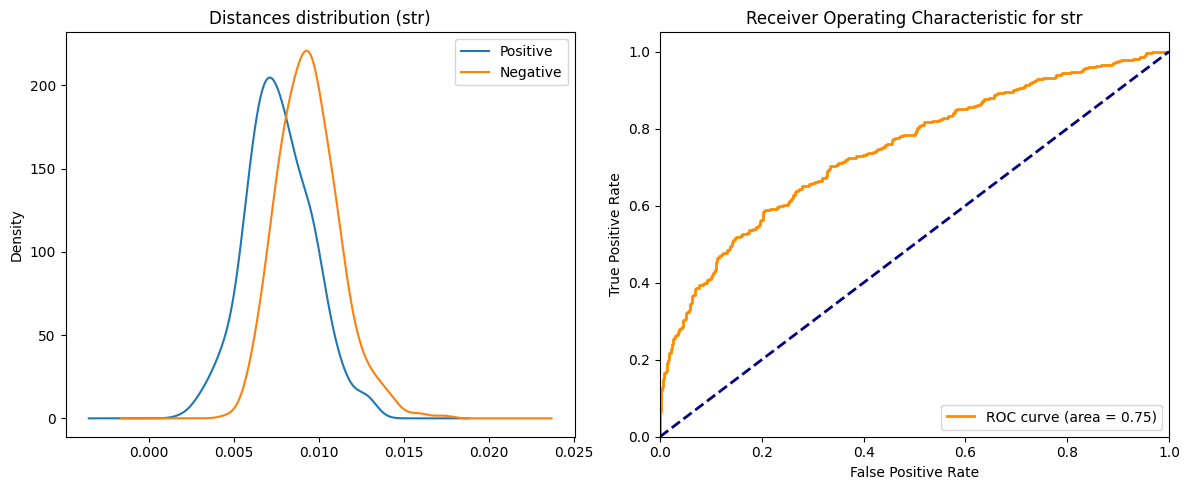

Target FAR: 1e-03 | Threshold: 0.0047
[epoch_11.pt] Accuracy: 0.5310
[epoch_11.pt] VAL: 0.0620 | FAR: 0.0000

[epoch_11.pt] Positive mean: 0.0076 ± 0.0020
[epoch_11.pt] Negative mean: 0.0094 ± 0.0018


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 106.76it/s]


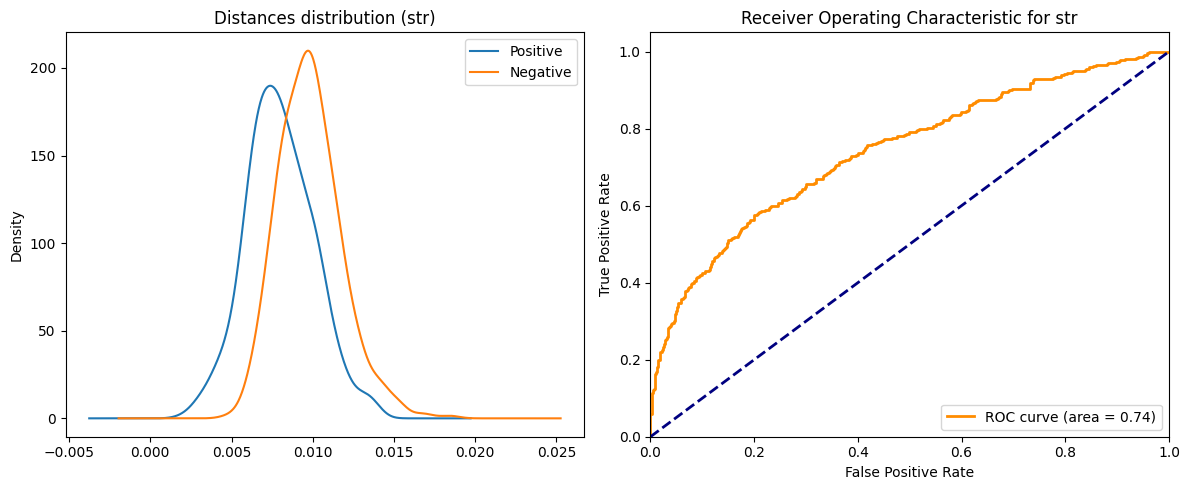

Target FAR: 1e-03 | Threshold: 0.0048
[epoch_12.pt] Accuracy: 0.5290
[epoch_12.pt] VAL: 0.0580 | FAR: 0.0000

[epoch_12.pt] Positive mean: 0.0080 ± 0.0021
[epoch_12.pt] Negative mean: 0.0098 ± 0.0020


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 102.39it/s]


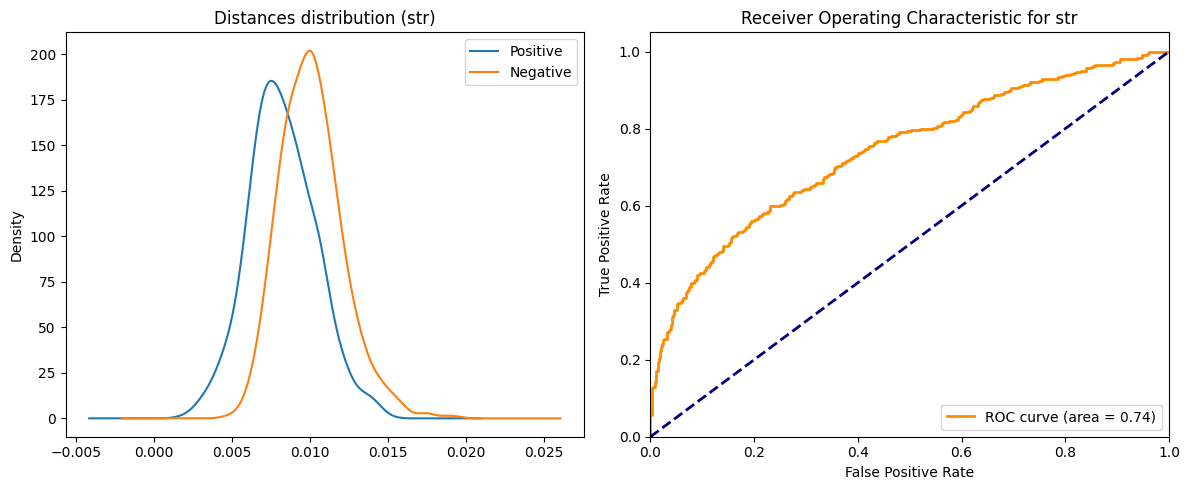

Target FAR: 1e-03 | Threshold: 0.0049
[epoch_13.pt] Accuracy: 0.5270
[epoch_13.pt] VAL: 0.0540 | FAR: 0.0000

[epoch_13.pt] Positive mean: 0.0082 ± 0.0021
[epoch_13.pt] Negative mean: 0.0101 ± 0.0020


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 90.91it/s] 


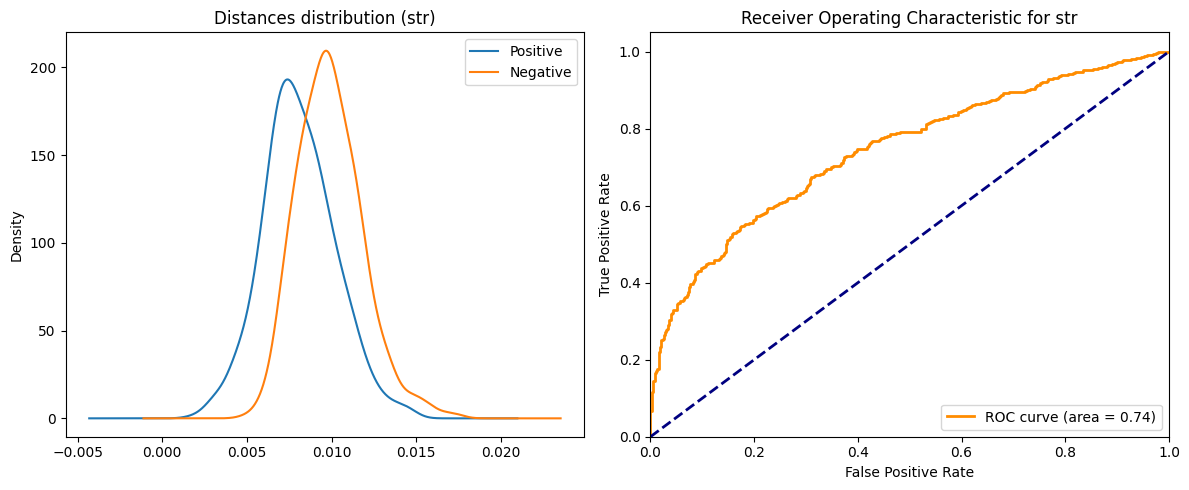

Target FAR: 1e-03 | Threshold: 0.0050
[epoch_14.pt] Accuracy: 0.5320
[epoch_14.pt] VAL: 0.0640 | FAR: 0.0000

[epoch_14.pt] Positive mean: 0.0081 ± 0.0021
[epoch_14.pt] Negative mean: 0.0099 ± 0.0019


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 67.36it/s]


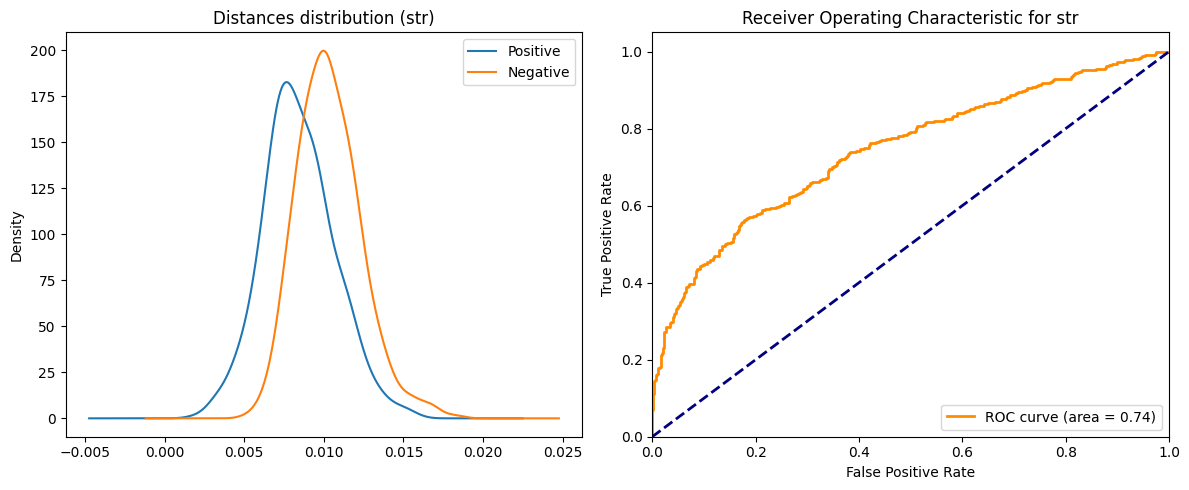

Target FAR: 1e-03 | Threshold: 0.0053
[epoch_15.pt] Accuracy: 0.5340
[epoch_15.pt] VAL: 0.0680 | FAR: 0.0000

[epoch_15.pt] Positive mean: 0.0084 ± 0.0022
[epoch_15.pt] Negative mean: 0.0104 ± 0.0020


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 67.44it/s]


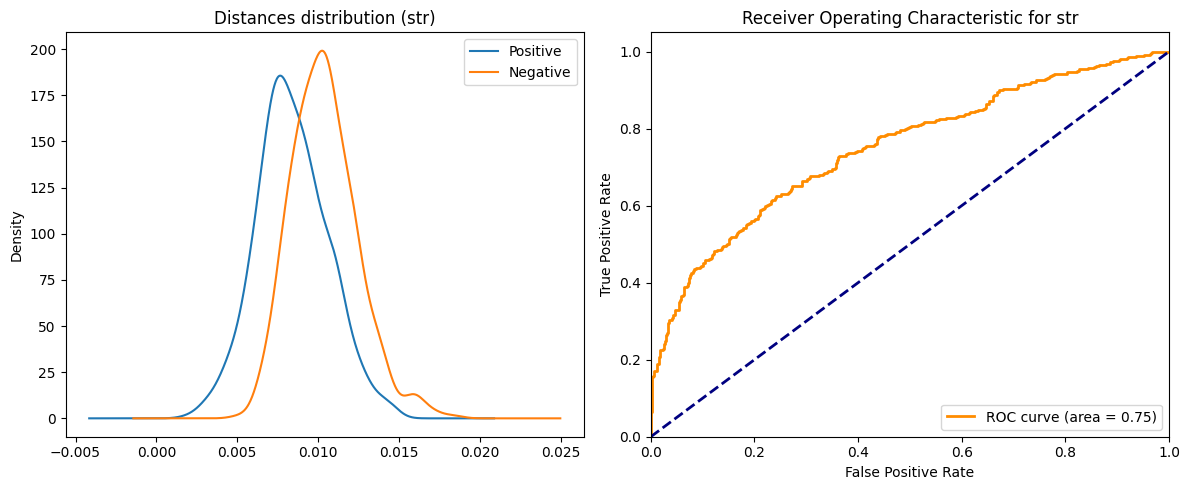

Target FAR: 1e-03 | Threshold: 0.0052
[epoch_16.pt] Accuracy: 0.5310
[epoch_16.pt] VAL: 0.0620 | FAR: 0.0000

[epoch_16.pt] Positive mean: 0.0084 ± 0.0022
[epoch_16.pt] Negative mean: 0.0104 ± 0.0020


In [4]:
eval_epochs(epochs_path=EPOCHS_PATH, 
            pairs=pairs,
            model_class=Omoindrot, 
            batch_size=32, 
            transform=simple_transform, 
            device=device,
            target_far=1e-3)

# **Collapse**

In [5]:
model = Omoindrot(emb_size=64)
model.eval()
model.to(device)

# Carregar o modelo mais treinado
model_path = os.path.join(EPOCHS_PATH, 'epoch_8.pt')
load = torch.load(model_path)
load = {k.replace('_orig_mod.', ''): v for k, v in load.items()}
model.load_state_dict(load)

# Extrair um unico embedding de uma imagem
dataset = MNISTSingleDataset(test_df, transform=simple_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=False, pin_memory=True, num_workers=0)

with torch.no_grad():
    for (imgs, labels) in dataloader:
        images = imgs.to(device)
        emb = model(images).cpu().numpy()
        break

print(emb)

# Calcular a distancia entre dois embeddings usando torch.norm
emb1 = torch.tensor([emb[0]])
emb2 = torch.tensor([emb[1]])

# Printar as labels dos embeddings
print(test_df.iloc[0]['label'])
print(test_df.iloc[1]['label'])

dist = torch.norm(emb1 - emb2, p=2)
print(dist.item())

[[-0.1019922   0.23856224  0.00687983 -0.24867427 -0.00450443 -0.07868991
  -0.07219516 -0.07630118 -0.08847642 -0.18018459  0.07882547  0.05791732
  -0.00050548 -0.09810194 -0.24915972 -0.02642071 -0.07735807  0.05470314
  -0.19516774 -0.26136288  0.11858553 -0.05662527 -0.1443767   0.09881552
   0.05933445 -0.02938212  0.01853227  0.13752426 -0.21120276  0.19103496
  -0.08208372  0.1707051  -0.12072879  0.16097221 -0.09761031  0.07290892
  -0.1432666  -0.12569955 -0.02232628 -0.01446287 -0.15751627  0.03797395
  -0.21006669  0.01449439 -0.19075094  0.07115492  0.03627836  0.10028435
  -0.05850098 -0.17529076  0.13611342 -0.12202012  0.13073514 -0.037552
   0.09854615 -0.02927691 -0.1774811  -0.07340264  0.08230782  0.0383573
  -0.01965799 -0.0050396   0.03427832 -0.26130334]
 [-0.09986331  0.23945446  0.00819289 -0.24903883 -0.00231578 -0.08047679
  -0.07332706 -0.07522188 -0.08937518 -0.17998126  0.08022942  0.05728291
   0.0014923  -0.09879173 -0.25076368 -0.02581446 -0.07633699  0

/tmp/ipykernel_7668/1887220947.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  emb1 = torch.tensor([emb[0]])


# **Visualizar os embeddings**

In [6]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, RandomAffine

In [7]:
import os

def view_embs(epochs_path, model_class):
    models_name = os.listdir(epochs_path)
    models_name_sorted = sorted(models_name, key=lambda x: int(x.replace('.pt', '').split('_')[1]))
        
    modelo = model_class(emb_size=64).to(device)
    modelo.eval()
    
    test_dataset = MNISTSingleDataset(test_df, transform=simple_transform)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=0)
    
    for model in models_name_sorted:        
        model_path = os.path.join(epochs_path, model)
        load = torch.load(model_path)
        load = {k.replace('_orig_mod.', ''): v for k, v in load.items()}
        modelo.load_state_dict(load)

        embeddings = []
        with torch.no_grad():
            for (imgs, labels) in test_dataloader:
                images = imgs.to(device)
                embeddings.append(modelo(images).cpu().numpy())

        embeddings = np.concatenate(embeddings)
        
        # Reduzir dimensionalidade
        tsne = TSNE(n_components=2, perplexity=30, max_iter=300)
        embeddings_2d = tsne.fit_transform(embeddings)
        
        # Plotar embeddings
        plt.figure(figsize=(12, 8))
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=test_df['label'], cmap='tab10', s=1)
        plt.colorbar()
        plt.show()
        
#view_embs(EPOCHS_PATH, Omoindrot)